In [1]:
import os
import random
import numpy as np
from PIL import Image

import matplotlib.pyplot as plt
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import transforms

In [2]:
MODEL_NAME = "gray_to_rgb_model.pth"
MODEL_PATH = os.path.join("..", "models", MODEL_NAME)

BASE_DIR = os.path.join("..", "data", "coco")
TRAIN_DIR = os.path.join(BASE_DIR, "train")
VAL_DIR = os.path.join(BASE_DIR, "val")
TEST_DIR = os.path.join(BASE_DIR, "test")

In [3]:
IMG_SIZE = 64
EPOCHS = 5
BATCH_SIZE = 100
BLOCK_1_CHANNELS = 64
BLOCK_2_CHANNELS = 128
BLOCK_3_CHANNELS = 256
BLOCK_4_CHANNELS = 512
BOTTLENECK_CHANNELS = 1024
LEARNING_RATE = 0.001
WEIGHT_DECAY = 1e-5

In [4]:
SEED_VALUE = 42
random.seed(SEED_VALUE)
os.environ['PYTHONHASHSEED'] = str(SEED_VALUE)
torch.manual_seed(SEED_VALUE)
torch.cuda.manual_seed(SEED_VALUE)
torch.cuda.manual_seed_all(SEED_VALUE)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [6]:
class IMGDataset(torch.utils.data.Dataset):
    def __init__(self, folder):
        self.files = sorted([os.path.join(folder, f) for f in os.listdir(folder) if f.endswith(('.jpg', '.png'))])

        gray_transforms_list = [
            transforms.Resize((IMG_SIZE, IMG_SIZE)),
            transforms.Grayscale(num_output_channels=1)
        ]

        if folder.endswith("train"):
            gray_transforms_list += [
                transforms.RandomRotation(10),
                transforms.ColorJitter(brightness=0.1, contrast=0.1)
            ]

        gray_transforms_list += [
            transforms.ToTensor(),
            transforms.Normalize([0.5], [0.5])
        ]

        self.gray_transform = transforms.Compose(gray_transforms_list)

        self.color_transform = transforms.Compose([
            transforms.Resize((IMG_SIZE, IMG_SIZE)),
            transforms.ToTensor(),
            transforms.Normalize([0.5]*3, [0.5]*3)
        ])

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        img = Image.open(self.files[idx]).convert("RGB")
        gray = self.gray_transform(img)
        original = self.color_transform(img)
        return gray, original

In [7]:
train_dataset = IMGDataset(TRAIN_DIR)
val_dataset = IMGDataset(VAL_DIR)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=1, pin_memory=True)

In [8]:
class Model(nn.Module):
    def __init__(self, block_1_channels, block_2_channels, block_3_channels, block_4_channels, bottleneck_channels):
        super().__init__()
        self.enc1 = self.encoder_block(1, block_1_channels)
        self.enc2 = self.encoder_block(block_1_channels, block_2_channels)
        self.enc3 = self.encoder_block(block_2_channels, block_3_channels)
        self.enc4 = self.encoder_block(block_3_channels, block_4_channels)
        self.bottleneck = self.encoder_block(block_4_channels, bottleneck_channels)
        
        self.up4 = self.decoder_block(bottleneck_channels, block_4_channels)
        self.up3 = self.decoder_block(block_4_channels*2, block_3_channels)
        self.up2 = self.decoder_block(block_3_channels*2, block_2_channels)
        self.up1 = self.decoder_block(block_2_channels*2, block_1_channels)

        self.final_conv = nn.Conv2d(block_1_channels*2, 3, kernel_size=1)

    def encoder_block(self, in_channels, out_channels):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, 3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
        )

    def decoder_block(self, in_channels, out_channels):
        return nn.Sequential(
            nn.ConvTranspose2d(in_channels, out_channels, 2, stride=2),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, 3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
        )

    def forward(self, x):
        e1 = self.enc1(x)
        e2 = self.enc2(F.max_pool2d(e1, 2))
        e3 = self.enc3(F.max_pool2d(e2, 2))
        e4 = self.enc4(F.max_pool2d(e3, 2))

        b = self.bottleneck(F.max_pool2d(e4, 2))

        d4 = self.up4(b)
        d4 = torch.cat((d4, e4), dim=1)

        d3 = self.up3(d4)
        d3 = torch.cat((d3, e3), dim=1)

        d2 = self.up2(d3)
        d2 = torch.cat((d2, e2), dim=1)

        d1 = self.up1(d2)
        d1 = torch.cat((d1, e1), dim=1)

        return torch.tanh(self.final_conv(d1))

In [9]:
def train_model(
    device,
    model,
    optimizer, loss_fn,
    train_loader):
    
    model.train()
    total_loss = 0.0
    train_loop = tqdm(train_loader, desc="Training")
    for x, y in train_loop:
        x, y = x.to(device), y.to(device)

        output = model(x)

        loss = loss_fn(output, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss

        train_loop.set_postfix(loss=loss.item())

    return total_loss

In [10]:
def evaluate_model(
    device,
    model,
    loss_fn,
    val_loader):
    
    model.eval()
    total_loss = 0.0
    val_loop = tqdm(val_loader, desc="Validation")
    with torch.no_grad():
        for x, y in val_loop:
            x, y = x.to(device), y.to(device)
            output = model(x)

            loss = loss_fn(output, y)
            total_loss += loss

            val_loop.set_postfix(loss=loss.item())

    return total_loss

In [11]:
def show_gray_vs_rgb(gray_batch, rgb_batch, n=5):
    gray_batch = gray_batch.cpu()
    rgb_batch = rgb_batch.cpu()
    
    plt.figure(figsize=(n*3, 6))
    
    for i in range(n):
        plt.subplot(2, n, i+1)
        plt.imshow(gray_batch[i].squeeze(), cmap='gray')
        plt.axis('off')
        if i == 0:
            plt.ylabel("Gray", fontsize=12)
        
        plt.subplot(2, n, i+n+1)
        img = rgb_batch[i].permute(1, 2, 0)
        img = (img * 0.5 + 0.5).clamp(0,1)
        plt.imshow(img)
        plt.axis('off')
        if i == 0:
            plt.ylabel("RGB", fontsize=12)

    plt.show()

In [12]:
model = Model(
    BLOCK_1_CHANNELS, BLOCK_2_CHANNELS, BLOCK_3_CHANNELS, BLOCK_4_CHANNELS,
    BOTTLENECK_CHANNELS
).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
loss_fn = nn.MSELoss()

Validation: 100%|██████████████████| 50/50 [00:20<00:00,  2.50it/s, loss=0.0321]


Epoch: 1
	train_loss: 0.0560
	val_loss: 0.0302

Model saved with val loss 0.0302.


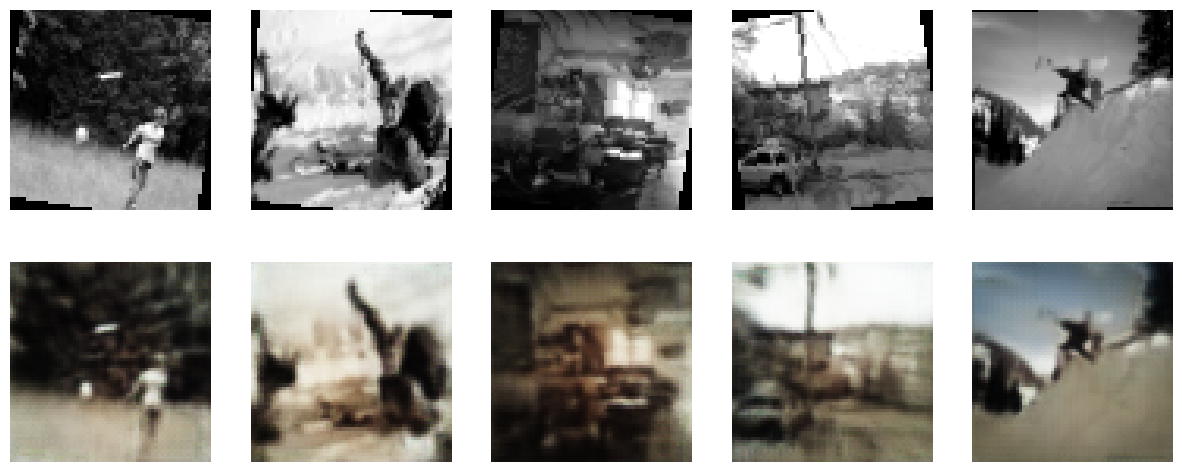

Validation: 100%|██████████████████| 50/50 [00:21<00:00,  2.29it/s, loss=0.0262]


Epoch: 2
	train_loss: 0.0371
	val_loss: 0.0259

Model saved with val loss 0.0259.


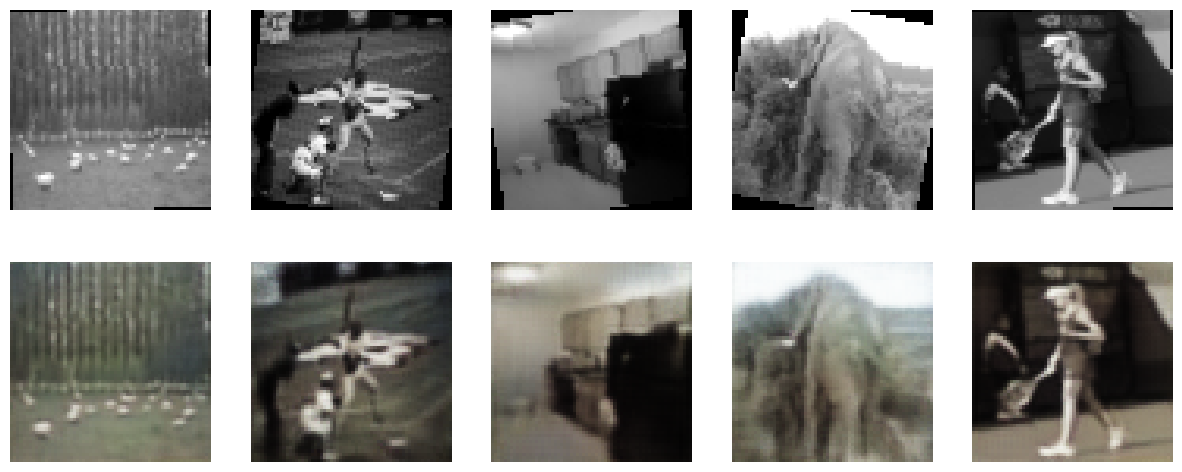

Validation: 100%|██████████████████| 50/50 [00:21<00:00,  2.38it/s, loss=0.0258]


Epoch: 3
	train_loss: 0.0345
	val_loss: 0.0255

Model saved with val loss 0.0255.


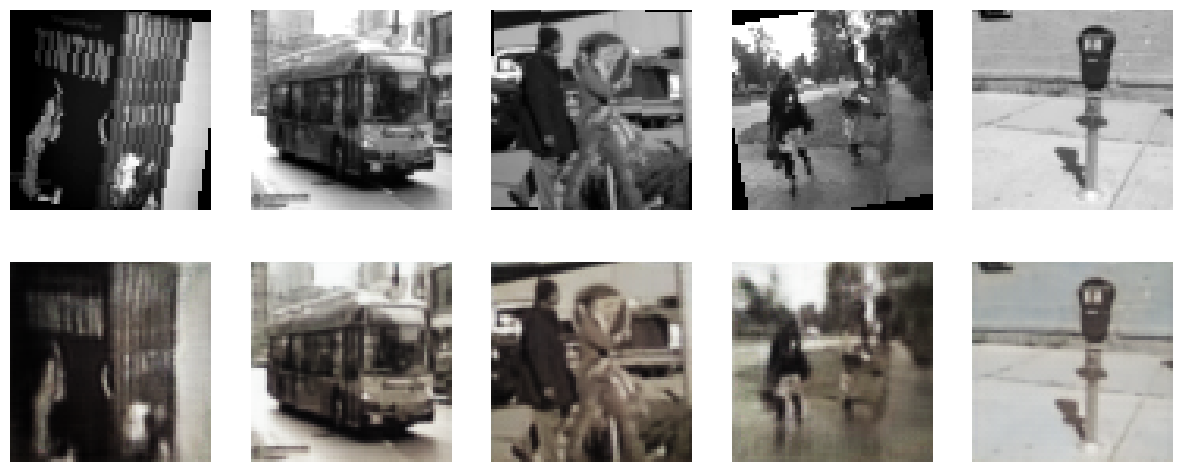

Validation: 100%|██████████████████| 50/50 [00:22<00:00,  2.23it/s, loss=0.0275]

Epoch: 4
	train_loss: 0.0327
	val_loss: 0.0264



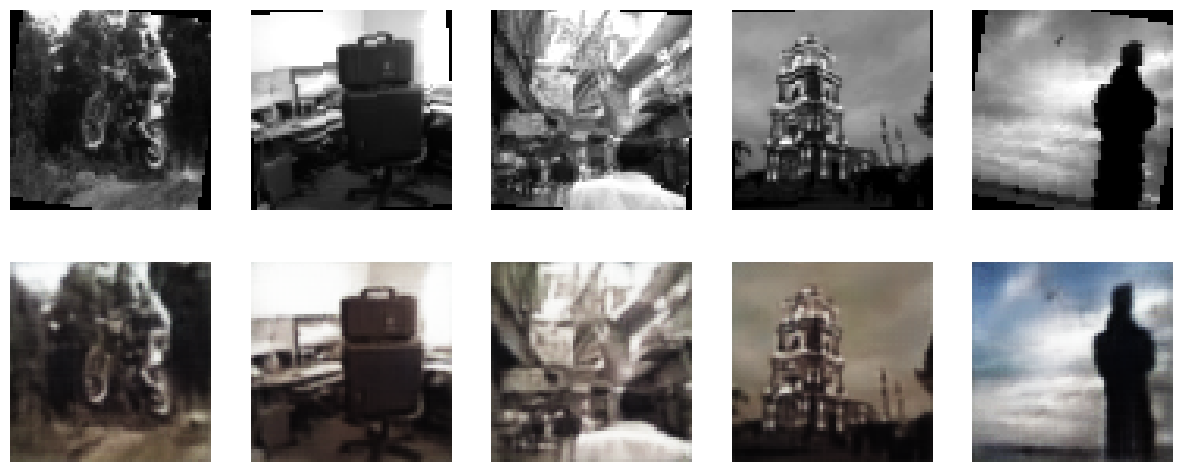

Validation: 100%|██████████████████| 50/50 [00:20<00:00,  2.42it/s, loss=0.0257]


Epoch: 5
	train_loss: 0.0314
	val_loss: 0.0242

Model saved with val loss 0.0242.


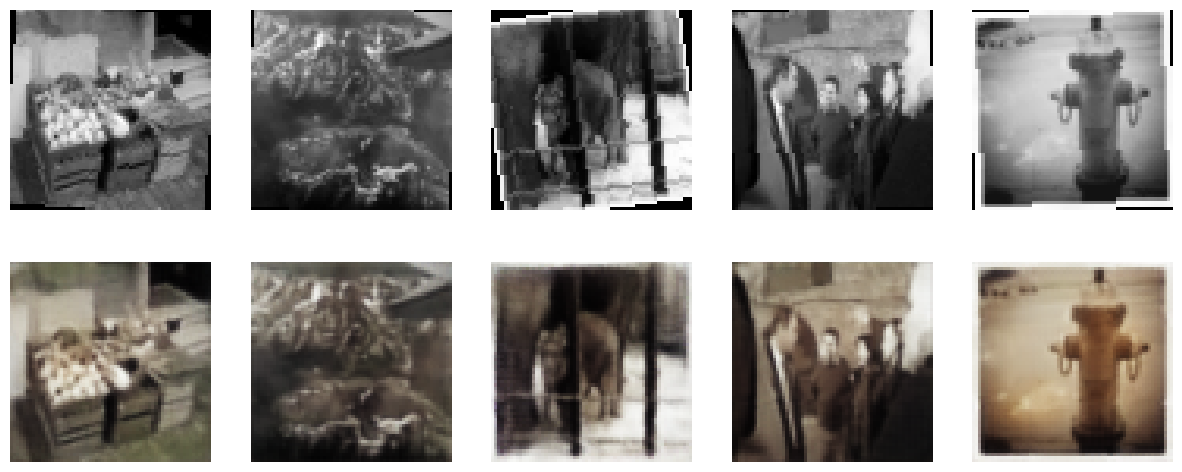

In [13]:
train_total_loss = []
val_total_loss = []

best_val_loss = float('inf')

for epoch in range(1, EPOCHS+1):
    train_loss = train_model(device, model, optimizer, loss_fn, train_loader)
    val_loss = evaluate_model(device, model, loss_fn, val_loader)
    
    train_loss /= len(train_loader)
    val_loss /= len(val_loader)

    train_total_loss.append(train_loss.item())
    val_total_loss.append(val_loss.item())

    print(f"Epoch: {epoch}\n\ttrain_loss: {train_loss:.4f}\n\tval_loss: {val_loss:.4f}\n")

    torch.cuda.empty_cache()

    if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'loss': val_loss
            }, MODEL_PATH)
            print(f"Model saved with val loss {val_loss:.4f}.")

    model.eval()
    with torch.no_grad():
        x, y = next(iter(train_loader))
        x, y = x[:5].to(device), y[:5].to(device)
        outputs = model(x)
        show_gray_vs_rgb(x, outputs, n=5)
    model.train()

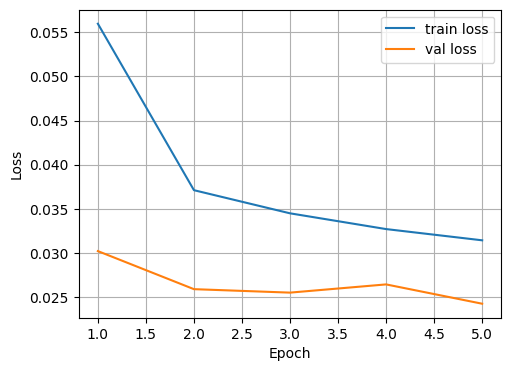

In [14]:
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(range(1, EPOCHS+1), train_total_loss, label='train loss')
plt.plot(range(1, EPOCHS+1), val_total_loss, label='val loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)